Band 1 – Coastal Aerosol - Исследования побережья.

Band 2 – Blue - Батиметрическое картирование, отличающее почву от растительности и лиственное от хвойной растительности

Band 3 - Green - Подчеркивает пиковую растительность, что полезно для оценки силы растений

Band 4 - Red - Различает склоны растительности

Band 5 - Near Infrared (NIR) - Подчеркивает содержание биомассы и береговых линий

Band 6 - Short-wave Infrared (SWIR) 1 - Различает влажность почвы и растительности; пронизывает тонкие облака

Band 7 - Short-wave Infrared (SWIR) 2 - Улучшенная влажность почвы и растительности и проникновение тонких облаков

In [82]:
import rasterio as rast
import numpy as np
from rasterio import plot
import matplotlib.pyplot as plt
import math

workingDir = ''
bandsName = [1, 2, 3, 4, 5, 7]
paramsForNorm = {1 : [0.780, 4.705],
                 2 : [0.786, 2.380],
                 3 : [0.759, -1.40],
                 4 : [0.791, 2.491],
                 5 : [0.648, 11.669],
                 7 : [0.808, -2.325]}
threshold = 11000
threshold2 = 0.15
maxValueForPixel = 2**16 - 1

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def printRGB(r, g, b):
    redn = normalize(r)
    greenn = normalize(g)
    bluen = normalize(b)
    rgb = np.dstack((redn, greenn, bluen))
    plt.figure(figsize=(30,30))
    plt.imshow(rgb)

def radNorm(array, band):
    return array*paramsForNorm[band][0] - paramsForNorm[band][1]

def readBands(pathToDir):
    bands = {}
    for band in bandsName:
        path = workingDir + pathToDir + '/B' + str(band) + '.TIF'
        bands[band] = rast.open(path).read(1)
    return bands

def setBlack(minMaxValues):
    return minMaxValues[4][0], minMaxValues[3][0], minMaxValues[2][0]

def setRed(minMaxValues):
    return minMaxValues[4][1], minMaxValues[3][0], minMaxValues[2][0]

def setGreen(minMaxValues):
    return minMaxValues[4][0], minMaxValues[3][1], minMaxValues[2][0]

def setBlue(minMaxValues):
    return minMaxValues[4][0], minMaxValues[3][0], minMaxValues[2][1]
    
def changeDetection(pathToFirstDir, pathToSecondDir):
    bands1 = readBands(pathToFirstDir)
    bands2 = readBands(pathToSecondDir)
    for band in bandsName:
        bands1[band] = radNorm(bands1[band], band)
        bands2[band] = radNorm(bands2[band], band)
    minMaxValues1 = {}
    minMaxValues2 = {}
    for band in bandsName:
        minMaxValues1[band] = [bands1[band].min(), bands1[band].max()]
        minMaxValues2[band] = [bands2[band].min(), bands2[band].max()]
    
    n = bands1[1].shape[0]
    m = bands1[1].shape[1]
    resultR = bands1[4].copy()
    resultG = bands1[3].copy()
    resultB = bands1[2].copy()
    for i in range(n):
        for j in range(m):
            delta = {}
            for band in bandsName:
                delta[band] = bands1[band][i][j] - bands2[band][i][j]
            vectorSize = 0.0
            for band in bandsName:
                vectorSize += delta[band]**2
            vectorSize = math.sqrt(vectorSize)
            if vectorSize > threshold:
                resultR[i][j], resultG[i][j], resultB[i][j] = setBlack(minMaxValues1)
    
    return resultR, resultG, resultB

def NDVI(bands):
    np.seterr(divide = 'ignore', invalid = 'ignore')
    red = bands[4].astype(float)
    nir = bands[5].astype(float)
    ndvi = (nir - red) / (nir + red)
    return ndvi

def BI(bands):
    np.seterr(divide = 'ignore', invalid = 'ignore')
    red = bands[4].astype(float)
    nir = bands[5].astype(float)
    swir = bands[7].astype(float)
    blue = bands[2].astype(float)
    bi = ((red + swir) - (nir + blue)) / ((red + swir) + (nir + blue))
    return bi

def changeDetectionWithNdviAndBi(pathToFirstDir, pathToSecondDir):
    bands1 = readBands(pathToFirstDir)
    bands2 = readBands(pathToSecondDir)
#     for band in bandsName:
#         bands1[band] = radNorm(bands1[band], band)
#         bands2[band] = radNorm(bands2[band], band)
    minMaxValues1 = {}
    minMaxValues2 = {}
    for band in bandsName:
        minMaxValues1[band] = [bands1[band].min(), bands1[band].max()]
        minMaxValues2[band] = [bands2[band].min(), bands2[band].max()]
    ndvi1 = NDVI(bands1)
    ndvi2 = NDVI(bands2)
    bi1 = BI(bands1)
    bi2 = BI(bands2)
    n = bands1[1].shape[0]
    m = bands1[1].shape[1]
    resultR = bands1[4].copy()
    resultG = bands1[3].copy()
    resultB = bands1[2].copy()
    for i in range(n):
        for j in range(m):
            deltaNdvi = ndvi2[i][j] - ndvi1[i][j]
            deltaBi = bi2[i][j] - bi1[i][j]
            if math.sqrt(deltaNdvi**2 + deltaBi**2) > threshold2:
                if deltaNdvi > 0 and deltaBi > 0:
                    resultR[i][j], resultG[i][j], resultB[i][j] = setBlue(minMaxValues1)
                elif deltaNdvi > 0 and deltaBi < 0:
                    resultR[i][j], resultG[i][j], resultB[i][j] = setGreen(minMaxValues1)
                elif deltaNdvi < 0 and deltaBi > 0:
                    resultR[i][j], resultG[i][j], resultB[i][j] = setRed(minMaxValues1)
                else:
                    resultR[i][j], resultG[i][j], resultB[i][j] = setBlack(minMaxValues1)
    return resultR, resultG, resultB

Синие зоны - зоны, где была вода, но теперь это суша. В случае Дохи это песок.

Зеленые зоны - зоны, где был песок, но теперь это зелень.

Черные зоны - зоны в которых появилась вода.

Красные зоны - зоны в которых вместо зелени появилась суша.

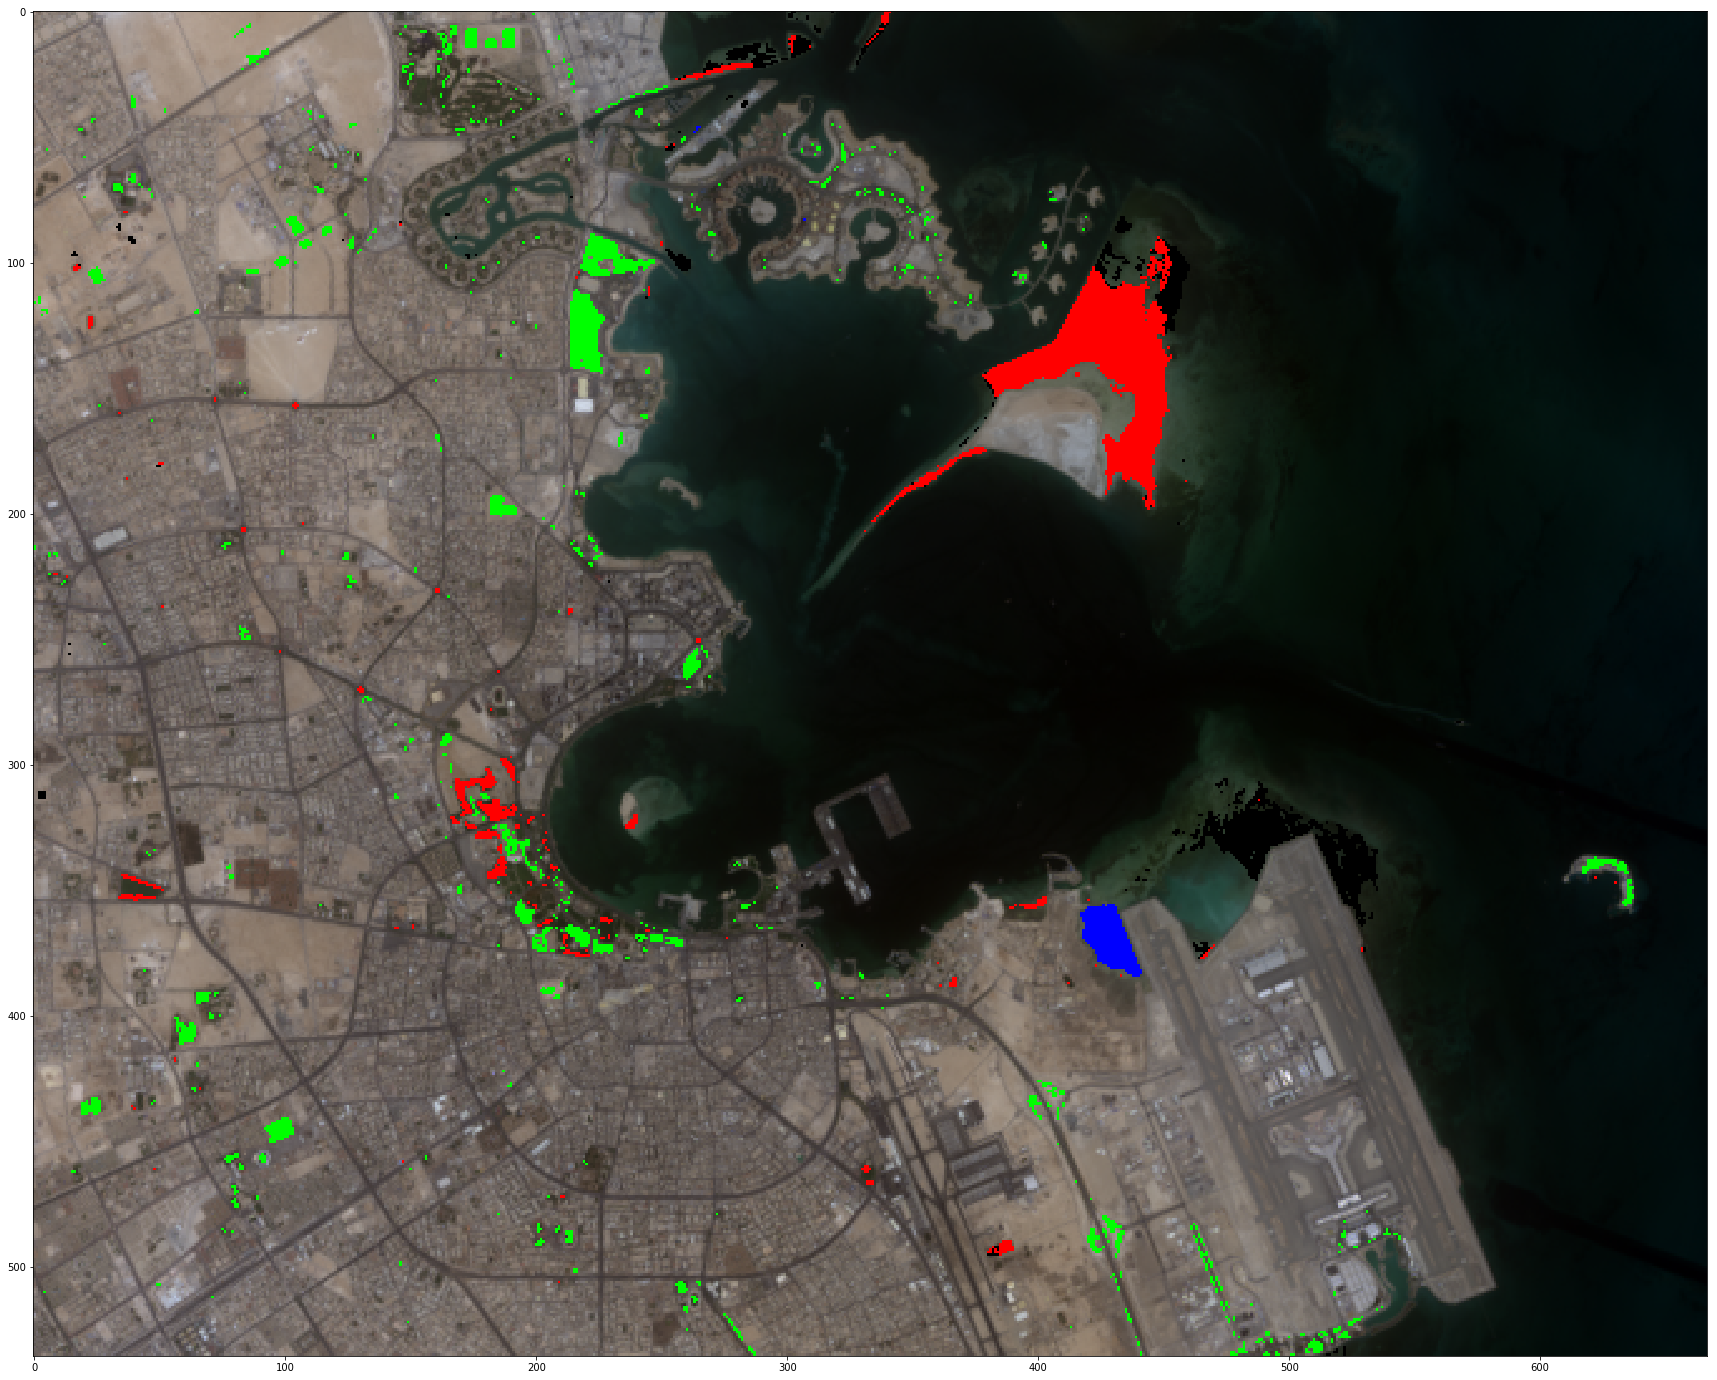

In [83]:
r, g, b = changeDetectionWithNdviAndBi('Doha_2013_Lands8', 'Doha_2019_Lands8')
printRGB(r, g, b)

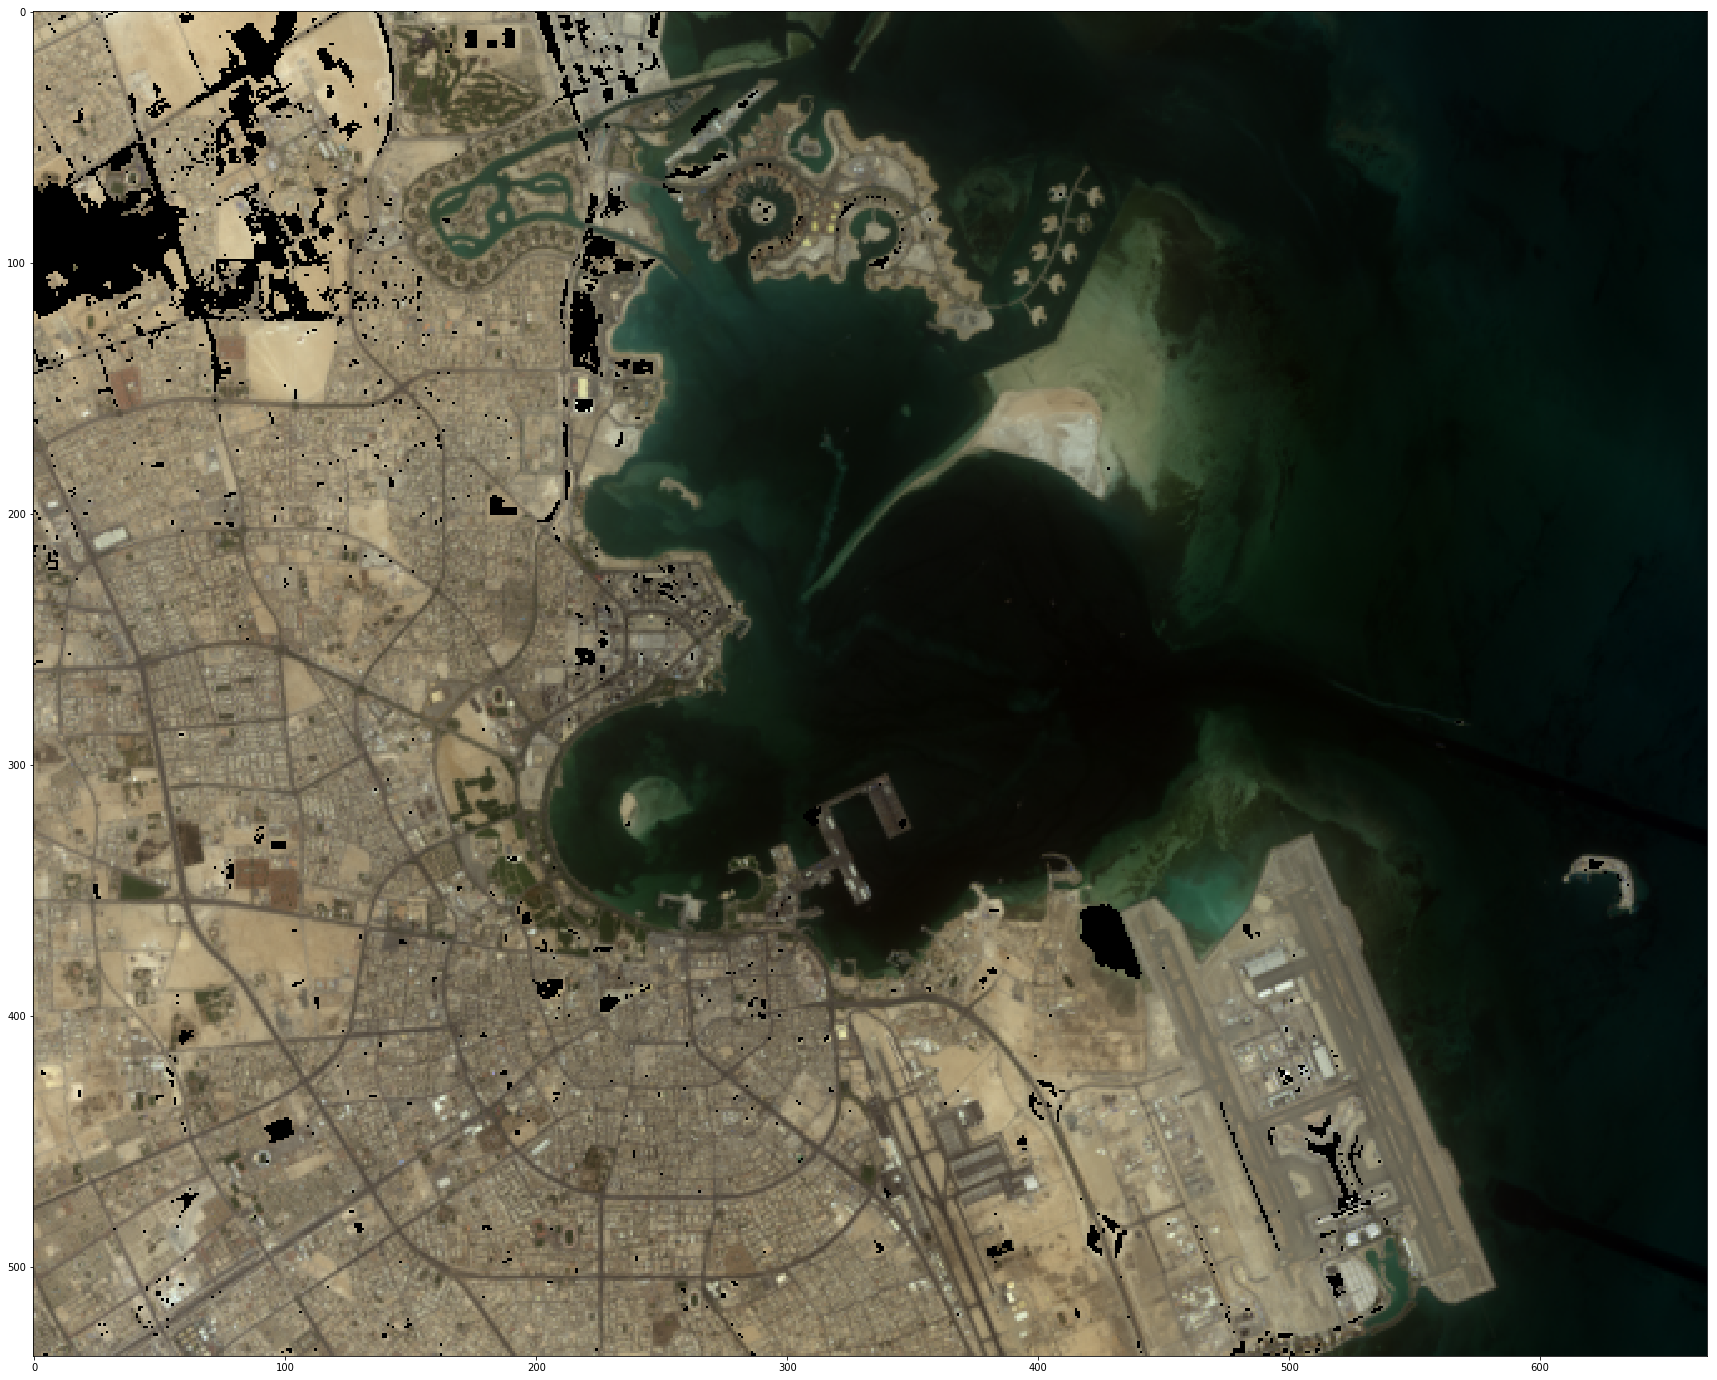

In [54]:
r, g, b = changeDetection('Doha_2013_Lands8', 'Doha_2019_Lands8')
printRGB(r, g, b)

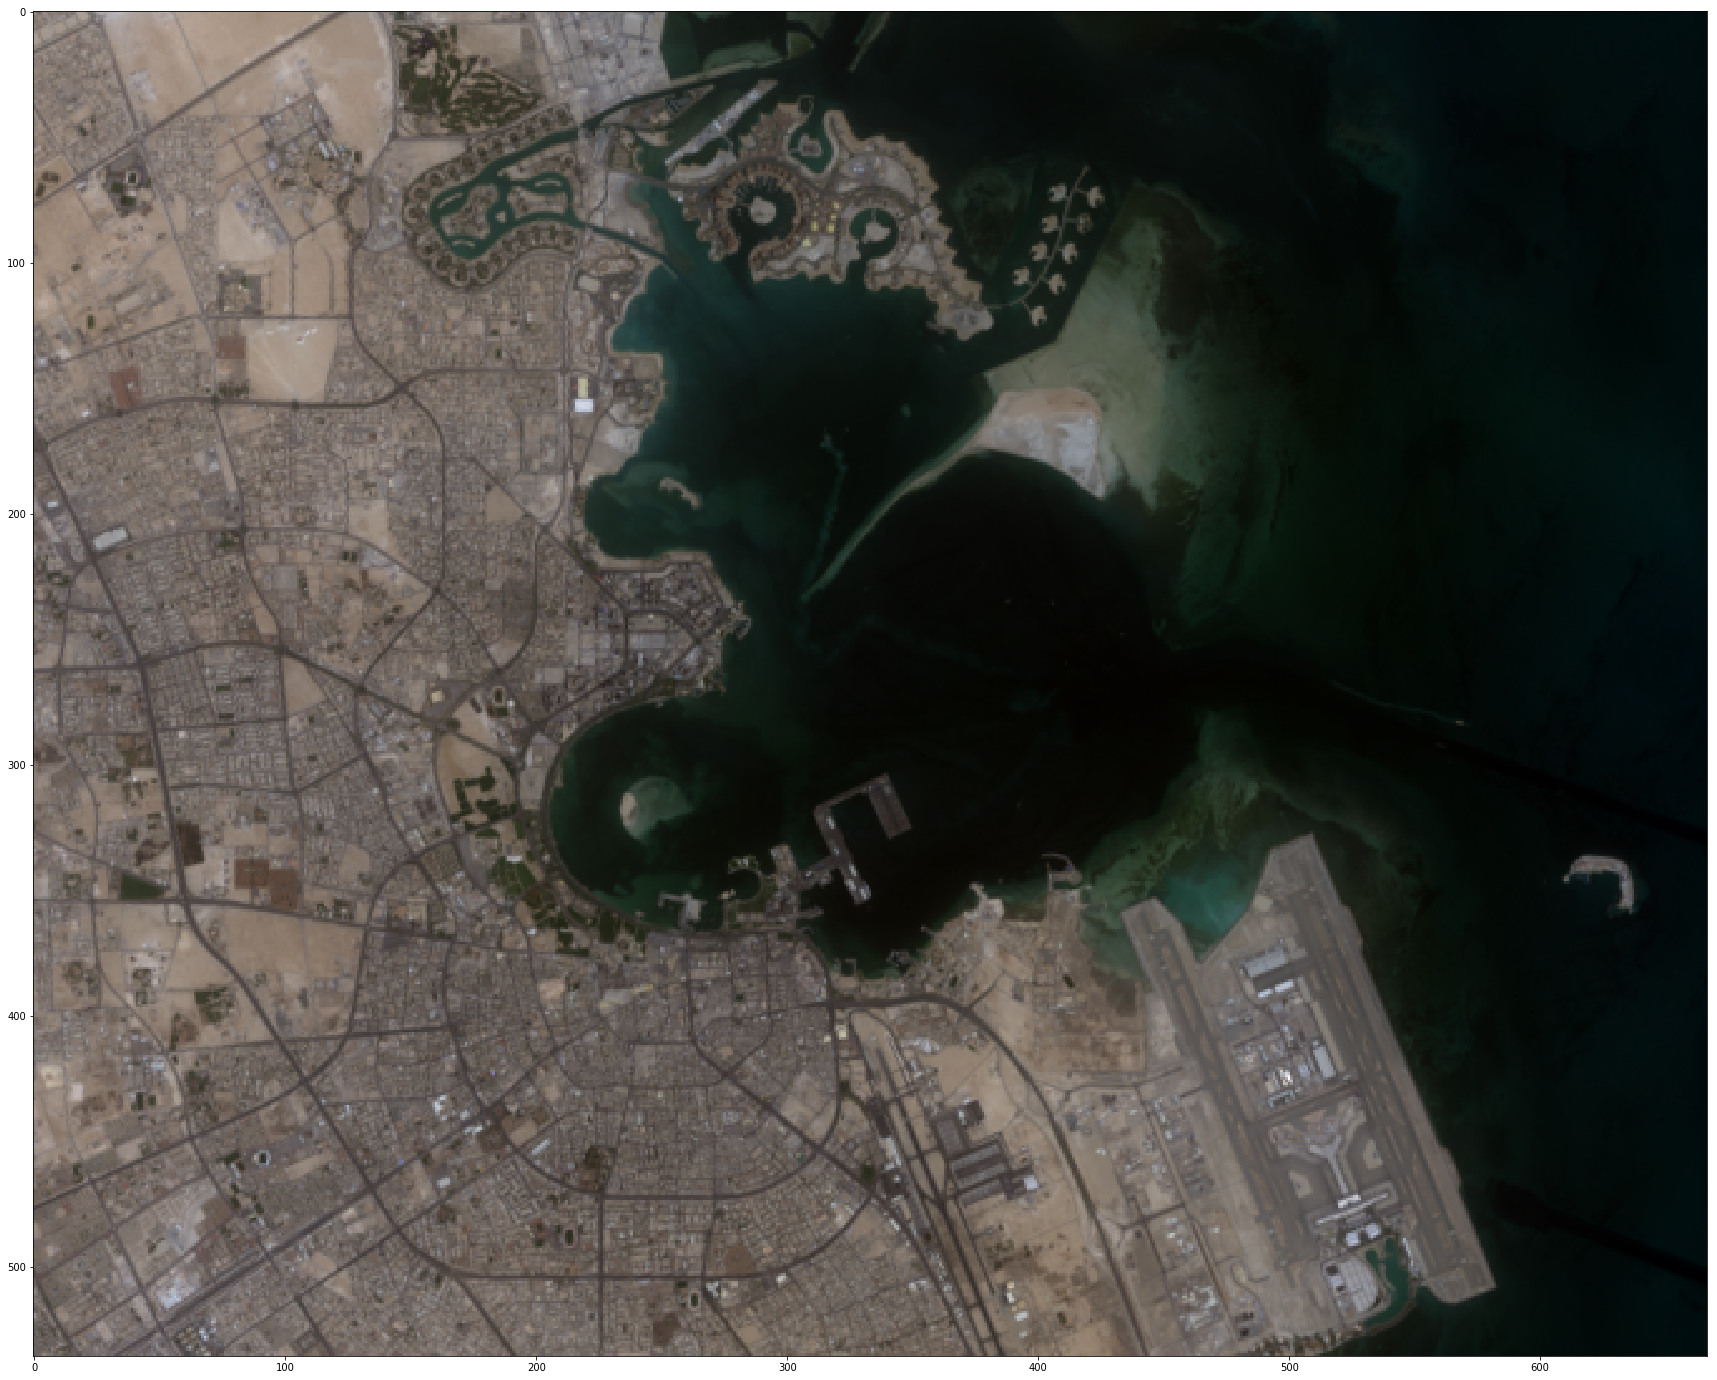

In [55]:
band1 = readBands('Doha_2013_Lands8')
printRGB(band1[4], band1[3], band1[2])

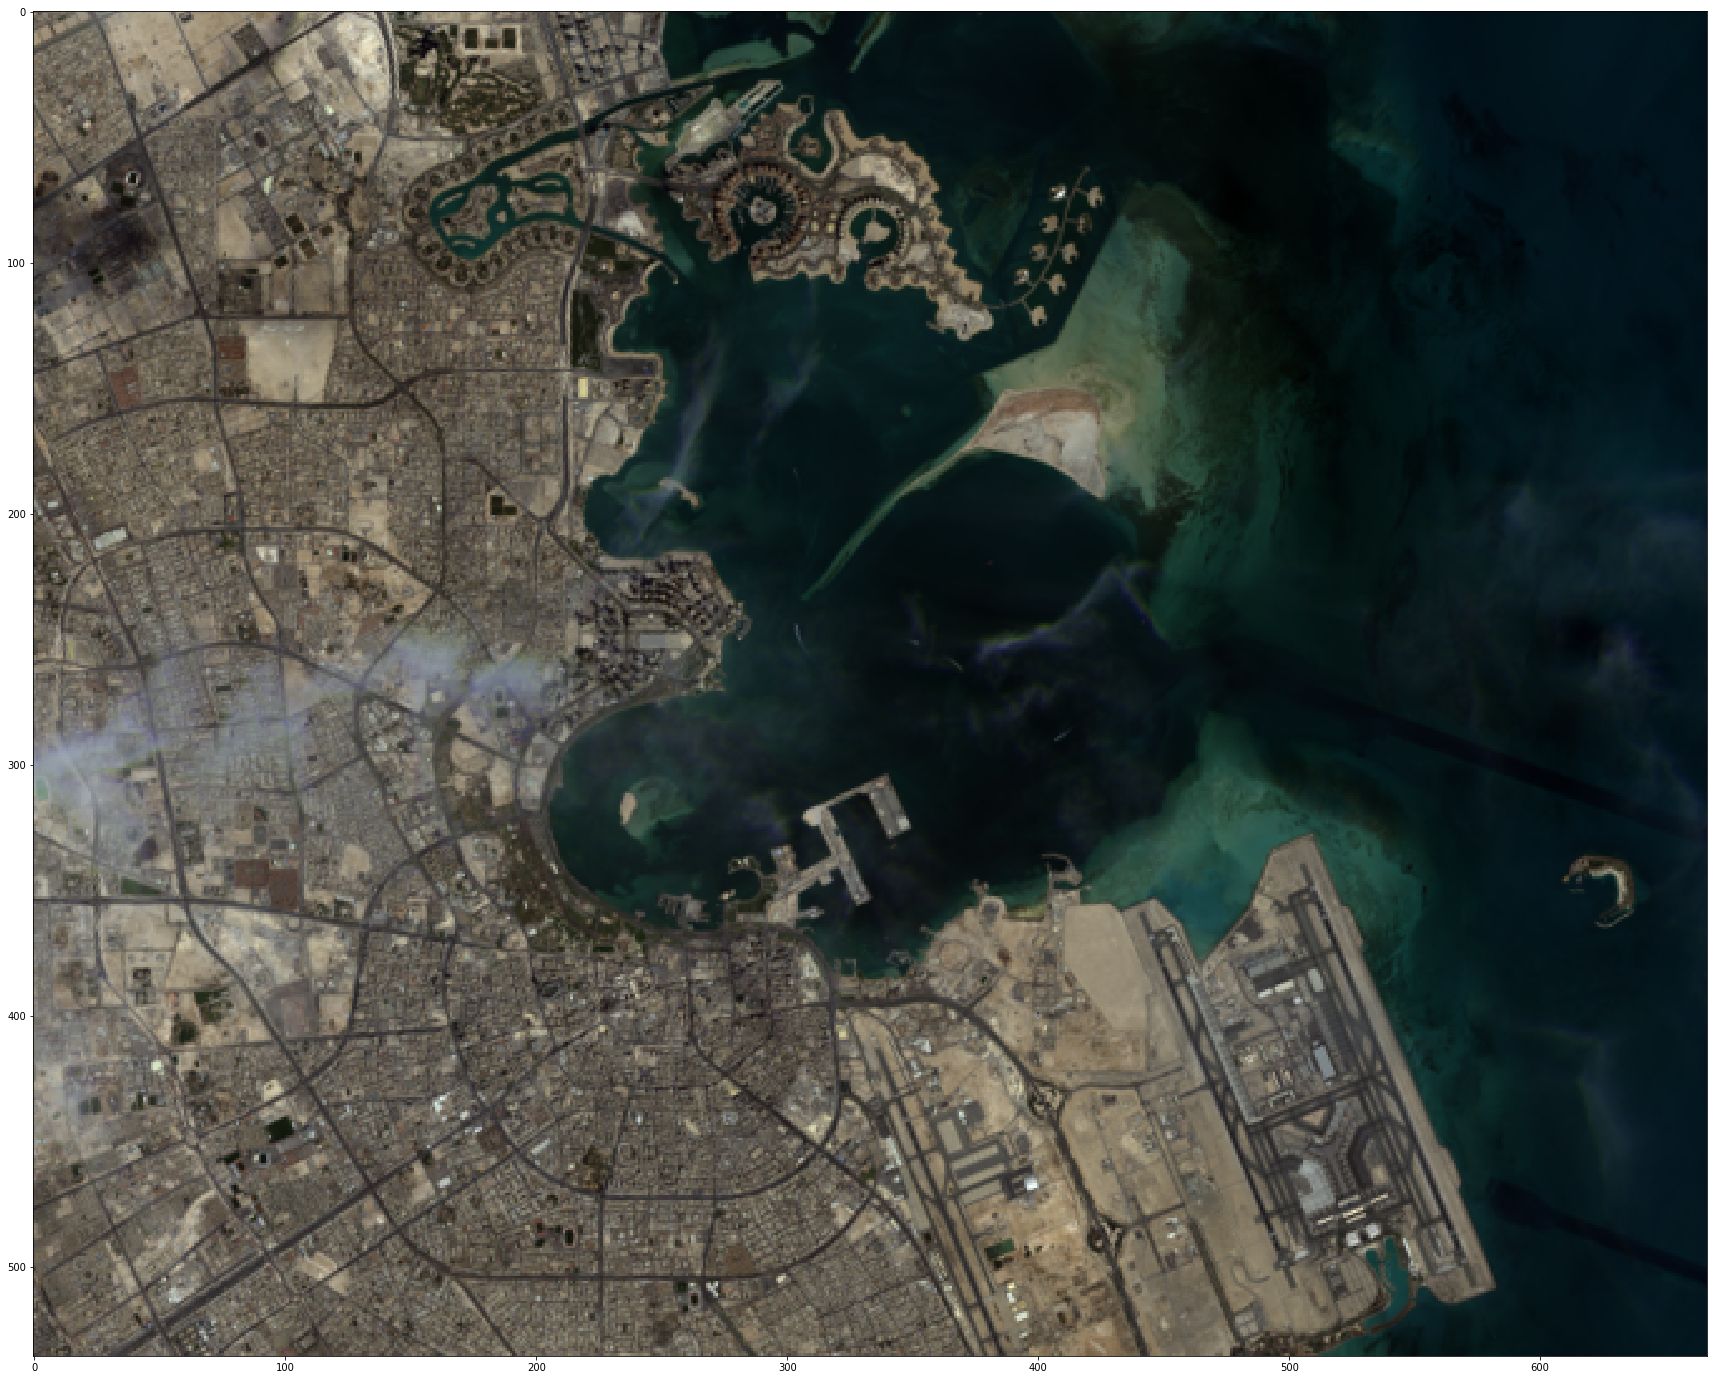

In [56]:
band2 = readBands('Doha_2019_Lands8')
printRGB(band2[4], band2[3], band2[2])